In [1]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import glob
from preproc import (
    load_and_preprocess_images,
    prepare_dataset,
    build_hard_example_pairs
)

from train_reconstruction import train_generator, generator, discriminator
from train_siamese import train_siamese

from config import (
    IMG_HEIGHT,
    IMG_WIDTH,
    IMG_CHANNELS,
    BATCH_SIZE_GEN,
    EPOCHS_GEN,
)

Using device: mps


In [2]:
#example_dataset = np.random.rand(100, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)  # Example dataset for testing purposes

#data_train      = load_and_preprocess_images(example_dataset,pad_value=0)

paths_train_1   = np.array(sorted(sorted(glob.glob('/Users/branko/env_anomalib/datasets/MVTec/lung/train/good_1/*')),key=len))
paths_train_2   = np.array(sorted(sorted(glob.glob('/Users/branko/env_anomalib/datasets/MVTec/lung/train/good_2/*')),key=len))
paths_train     = np.concatenate((paths_train_1,paths_train_2))
paths_test      = sorted(sorted(glob.glob('/Users/branko/env_anomalib/datasets/MVTec/lung/test/curated_bad/*')),key=len)[:50]

data_train       = load_and_preprocess_images(paths_train,pad_value=0)
data_test        = load_and_preprocess_images(paths_test,pad_value=0)

data_train[data_train>0] = 0
data_train = 2*(data_train)+1

data_test[data_test>0] = 0
data_test = 2*(data_test)+1

X_train, Y_train = prepare_dataset(data_train, augment=True)
X_test, Y_test = prepare_dataset(data_test, augment=False)

# Pick device once for inference convenience
DEVICE = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()
    else torch.device("cpu")
)

def create_placeholder_dataset(X_train, Y_train, batch_size):
    x = X_train.astype('float32')
    y = Y_train.astype('float32')
    # NHWC -> NCHW
    x = np.transpose(x, (0, 3, 1, 2))
    y = np.transpose(y, (0, 3, 1, 2))
    ds = TensorDataset(torch.from_numpy(x), torch.from_numpy(y))
    return DataLoader(ds, batch_size=batch_size, shuffle=True)

def run_inference(preprocessed_input, ground_truth, generator_model):
    """
    preprocessed_input: (H,W,1) or (1,H,W,1) in [-1,1]
    """
    generator_model.eval()

    if preprocessed_input.ndim == 3:
        preprocessed_input = preprocessed_input[None, ...]  # add batch

    # NHWC -> NCHW
    inp = torch.from_numpy(np.transpose(preprocessed_input, (0, 3, 1, 2))).float().to(DEVICE)

    with torch.no_grad():
        out = generator_model(inp).detach().cpu().numpy()  # N,1,H,W

    out_img = np.transpose(out[0], (1, 2, 0))  # H,W,1

    fig, axs = plt.subplots(1, 4, figsize=(12.5, 5))
    axs[0].imshow(preprocessed_input[0, ..., 0], cmap='binary');   axs[0].set_title("Input");    axs[0].axis('off')
    axs[1].imshow(out_img[..., 0], cmap='binary_r');               axs[1].set_title("Output");   axs[1].axis('off')
    axs[2].imshow(ground_truth[..., 0], cmap='binary_r');          axs[2].set_title("GT");       axs[2].axis('off')
    axs[3].imshow(np.abs(out_img[..., 0] - ground_truth[..., 0]), cmap='viridis'); axs[3].set_title("Residual"); axs[3].axis('off')
    plt.tight_layout(); plt.show()
    return out_img

# ----- Synthetic example data -----
#example_dataset = np.random.rand(100, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS).astype(np.float32)
#data_train = load_and_preprocess_images(example_dataset, pad_value=0)

# Prepare (NHWC, in [-1,1])
# X_train, Y_train = prepare_dataset(data_train, augment=True)
# If you have real test data, prepare it here:
# X_test, Y_test = prepare_dataset(data_test, augment=False)

# ----- Train reconstruction GAN -----
dataloader = create_placeholder_dataset(X_train, Y_train, BATCH_SIZE_GEN)

Preparing Dataset: 100%|██████████| 50/50 [00:00<00:00, 812.31it/s]


In [ ]:
gen, disc = train_generator(dataloader, EPOCHS_GEN)

# Move to the same device we use for inference & pairs
gen.to(DEVICE)

# Example inference if you have test data:
out = run_inference(X_test[0], Y_test[0], gen)

In [3]:
# --- SAVE ---
#torch.save(gen.state_dict(), "gen_model_weights.pth")

# --- LOAD ---
generator.load_state_dict(torch.load("gen_model_weights.pth"))
generator.eval()  # use eval() when doing inference

Pix2PixHDGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNormalization(
      (norm): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    )
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNormalization(
      (norm): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    )
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNormalization(
      (norm): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    )
    (9): ReLU(inplace=True)
    (10): ResnetBlock(
      (pad1): ReflectionPad2d((1, 1, 1, 1))
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (in1): InstanceNormalization(
        (norm): InstanceNorm2d(256, eps=1e-

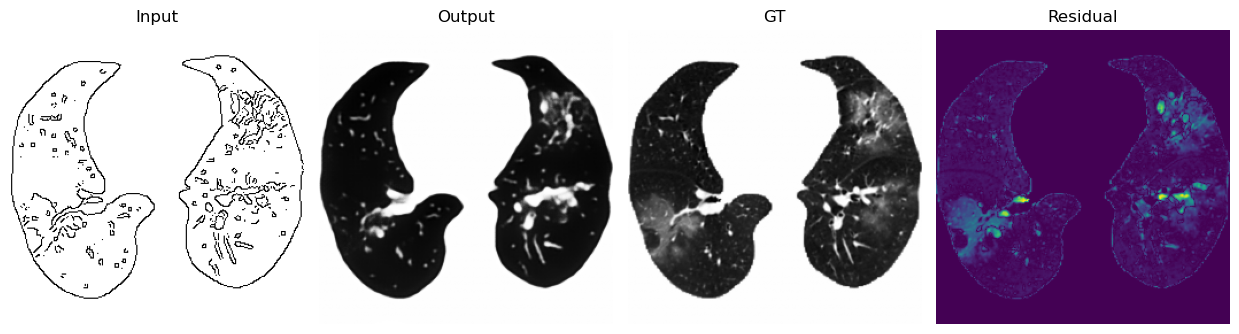

In [4]:
out = run_inference(X_test[0], Y_test[0], generator)

In [5]:
    # build_hard_example_pairs expects NHWC arrays in [-1,1]
    X_pairs, y_pairs = build_hard_example_pairs(generator, X_train, Y_train)
    siamese = train_siamese(X_pairs, y_pairs)

Hard example threshold: 0.060883
Epoch 1/10 - val_acc: 0.7888
Epoch 2/10 - val_acc: 0.7908
Epoch 3/10 - val_acc: 0.7907
Epoch 4/10 - val_acc: 0.7915
Epoch 5/10 - val_acc: 0.7972
Epoch 6/10 - val_acc: 0.7981
Epoch 7/10 - val_acc: 0.7982
Epoch 8/10 - val_acc: 0.7969
Epoch 9/10 - val_acc: 0.7965
Epoch 10/10 - val_acc: 0.7915


In [6]:
from inference import generate_final_anomaly_heatmap

ind = 0

final_anomaly_heatmap = generate_final_anomaly_heatmap(ind, X_test, Y_test, generator, siamese)

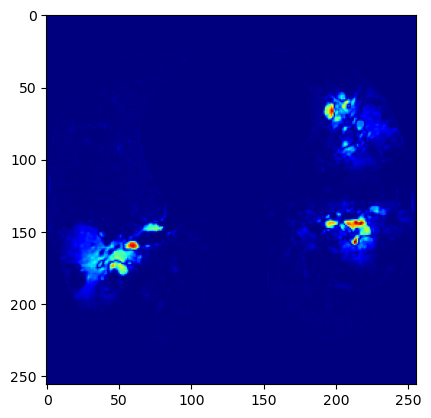

In [7]:
plt.imshow(final_anomaly_heatmap, cmap='jet')